In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
print("CUDA Available:", torch.cuda.is_available())
print("GPU Device Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")


CUDA Available: True
GPU Device Name: NVIDIA GeForce RTX 2080 Ti


In [3]:
import glob
import os, json, re
import warnings
import numpy as np
from datetime import datetime
from bokeh.io import export_svgs, output_notebook
from bokeh.models import BoxAnnotation, ColumnDataSource, HoverTool
from bokeh.plotting import figure, show
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    average_precision_score,
    precision_recall_curve,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

from utils.hidden_export import export_hidden_means_qpot, load_hidden_from_qpot_package
import utils.model_quan2 as mq
import utils.measuring_performance as measure_perform
from utils.misc import build_files_list, dump_pickle, load_pickle
from utils.sound_utils import (
    load_sound_file, 
    generate_sound_dataset, generate_gsensor_dataset, 
    extract_sound_features, extract_gsensor_features
)

output_notebook()
warnings.filterwarnings("ignore")
np.random.seed(42)

Loading BokehJS ...

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchinfo import summary
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torch.utils.tensorboard import SummaryWriter
from torch.optim import Adam, AdamW
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

from tqdm import tqdm

import snntorch as snn
from snntorch import surrogate
from snntorch import spikegen

The boolean variable `COMBINE_MACHINE_ID` allows you to decide whether to perform modeling separately for each machine ID, or combine all data from the same machine type to perform modeling.

In [5]:
DATA_PATH = "./data/tsri_factory"
SOUND_PATH = os.path.join(DATA_PATH, "sound")
GSENSOR_PATH = os.path.join(DATA_PATH, "gsensor")

IMAGE_PATH = "./img"
MODEL_PATH = "./models"
MERGE_OUTPUT_PATH = os.path.join(DATA_PATH, "dataset")
os.makedirs(MERGE_OUTPUT_PATH, exist_ok=True)

os.makedirs(os.path.join(DATA_PATH, "dataset"), exist_ok=True)
os.makedirs(MODEL_PATH, exist_ok=True)

file_paths = sorted([
    p for p in glob.glob(os.path.join(DATA_PATH, "*"))
    if os.path.isdir(p) and not p.endswith("dataset")
])
file_paths = [p for p in file_paths if os.path.isdir(p)]

# Data Splitting and Preprocessing

Because unsupervised learning is used, all anomalous labels are assigned to the test set.

In [6]:
normal_files, abnormal_files = build_files_list(root_dir=SOUND_PATH)
print(f"Normal: {len(normal_files)}, Abnormal: {len(abnormal_files)}")

normal_labels = np.zeros(len(normal_files))
abnormal_labels = np.ones(len(abnormal_files))

train_files, test_files, train_labels, test_labels = train_test_split(
    normal_files, normal_labels, train_size=0.75, random_state=42, shuffle=True
)

test_files = np.concatenate((test_files, abnormal_files), axis=0)
test_labels = np.concatenate((test_labels, abnormal_labels), axis=0)

test_indices = np.arange(len(test_files))
np.random.shuffle(test_indices)
test_files = test_files[test_indices]
test_labels = test_labels[test_indices]


print(
    f"Train set has {train_labels.shape[0]} signals including abnormal {train_labels.sum():.0f} signals, \
but test set has {test_labels.shape[0]} signals including abnormal {test_labels.sum():.0f} signals."
)

Normal: 412, Abnormal: 63
Train set has 309 signals including abnormal 0 signals, but test set has 166 signals including abnormal 63 signals.


In [7]:
dataset = {
    "train_files": train_files,
    "test_files": test_files,
    "train_labels": train_labels,
    "test_labels": test_labels,
}

for key, values in dataset.items():
    file_name = os.path.join(MERGE_OUTPUT_PATH, key + ".txt")
    with open(file_name, "w") as f:
        for item in values:
            f.write(str(item) + "\n")

In [8]:
# !del .\data\tsri_factory\dataset\train_*.pkl
# !del .\data\tsri_factory\dataset\test_*.pkl

In [9]:
# 音訊參數
n_fft = 2048
n_mels1, n_mels2 = 32, 64
frames1, frames2 = 5, 5

# 用 STFT 的 hop_length 根據取樣率調整相同frame
time_step = 6
frame_time_sec = 0.01

hop_length_sound = int(frame_time_sec * 48000)   # sound sample rate = 48kHz
hop_length_gsensor = int(frame_time_sec * 3600)  # gsensor sample rate = 3.6kHz

def build_split_dataset(split_name, file_list, out_dir):

    out_path       = os.path.join(out_dir, f"{split_name}_data_combined.pkl")
    out_prb_path   = os.path.join(out_dir, f"{split_name}_probs_combined.pkl")
    counts_path    = os.path.join(out_dir, f"{split_name}_frame_counts.pkl")
    slices_path    = os.path.join(out_dir, f"{split_name}_file_slices.pkl")
    filenames_path = os.path.join(out_dir, f"{split_name}_filenames.pkl")

    if all(os.path.exists(p) for p in [out_path, counts_path, slices_path, filenames_path]):
        print(f"{split_name.capitalize()} data & metadata already exist, loading from file...")
        return load_pickle(out_path)

    combined_spk_list = []
    combined_prb_list = []

    frame_counts  = []
    file_slices   = []
    filenames     = list(file_list)
    cursor        = 0

    gsensor_files = [
        os.path.join(GSENSOR_PATH, os.path.relpath(p, SOUND_PATH))
        for p in file_list
    ]

    print(f"Processing {split_name.upper()} per-file features and recording counts/slices...")

    for snd_path, g_path in tqdm(list(zip(file_list, gsensor_files)), total=len(file_list)):
        # ---------------------- Sound (per file) ----------------------
        snd_feats, snd_prb = generate_sound_dataset(
            [snd_path],
            n_fft=n_fft,
            time_step=time_step, 
            hop_length=hop_length_sound,   # hop = 0.01s
            n_mels=n_mels1,
            frames=frames1,
            fmax=3000,
            progress=False,
            normalization=True
        )  # (Ns, T=time_step, F_sound)

        # --------------------- Gsensor (per file) ---------------------
        gs_feats, gs_prb = generate_gsensor_dataset(
            [g_path],
            time_step=time_step,
            n_fft=n_fft,                  # or your gsensor-specific FFT size
            hop_length=hop_length_gsensor,
            n_mels=n_mels2,
            frames=frames2,
            fmax=1800,
            progress=False,
            normalization=True
        )

        # Align N across modalities
        Ns, Ng = snd_feats.shape[0], gs_feats.shape[0]
        if Ns != Ng:
            Nmin = min(Ns, Ng)
            snd_feats = snd_feats[:Nmin]
            gs_feats  = gs_feats[:Nmin]

            snd_prb = snd_prb[:Nmin]
            gs_prb  = gs_prb[:Nmin]

        # 檢查 time_step 維度
        assert snd_feats.shape[1] == gs_feats.shape[1] == time_step, "time_step mismatch"

        # Concatenate features on the last axis -> (N_i, T, F_total)
        comb = np.concatenate([snd_feats, gs_feats], axis=-1)
        # comb = snd_feats

        N_i = comb.shape[0]
        frame_counts.append(N_i)
        file_slices.append((cursor, cursor + N_i))
        cursor += N_i

        combined_spk_list.append(comb)


    combined_spk = np.concatenate(combined_spk_list, axis=0)


    dump_pickle(out_path, combined_spk)
    dump_pickle(counts_path, frame_counts)
    dump_pickle(slices_path, file_slices)
    dump_pickle(filenames_path, filenames)

    print(f"Saved {split_name} data to: {out_path}")
    print(f"Saved {split_name} frame_counts to: {counts_path}")
    print(f"Saved {split_name} file_slices to: {slices_path}")
    print(f"Saved {split_name} filenames to: {filenames_path}")

    return combined_spk


train_data = build_split_dataset("train", train_files, MERGE_OUTPUT_PATH)
test_data  = build_split_dataset("test",  test_files,  MERGE_OUTPUT_PATH)

print(f"Final TRAIN combined shape: {train_data.shape}")
print(f"Final TEST  combined shape: {test_data.shape}")


Train data & metadata already exist, loading from file...
Test data & metadata already exist, loading from file...
Final TRAIN combined shape: (1853073, 6, 480)
Final TEST  combined shape: (995502, 6, 480)


# Model Training

1. Surrogate Gradient : 訓練時反向傳播的近似函數。  

   推論階段（硬體）根本不需要 surrogate，因為推論只要「> threshold 就放電」的規則。  

---

2. init_hidden: 關係到「是否在 time step 之間保留膜電位」。  

   - `init_hidden=True` → 膜電位要在 memory/寄存器 中保存並在下一個 time step 繼續使用。  
   - `init_hidden=False` → 每個 time step 都 reset → 硬體只需組合邏輯，不需額外的 state memory。  


In [10]:
spike_grad = surrogate.fast_sigmoid()
lif = snn.Leaky(beta=0.75, spike_grad=spike_grad, init_hidden=True)

In [11]:
# Debug utilities 
def init_wu_dbg(warmup_spike: torch.Tensor) -> dict:
    """Create warm-up debug accumulator dict."""
    return {
        "wu_in_rate": warmup_spike.float().mean().item(),
        "wu_spk1_sum": 0.0,
        "wu_spk2_sum": 0.0,
        "wu_spk3_sum": 0.0,
        "wu_preout_mean_sum": 0.0,
        "wu_preout_abs_sum": 0.0,
        "wu_clip_steps": 0,
        "wu_steps": 0,
    }

def accum_wu_dbg(dbg: dict, spk1: torch.Tensor, spk2: torch.Tensor,
                 spk3: torch.Tensor, yt: torch.Tensor, clipped: bool) -> None:
    """Accumulate warm-up statistics per step."""
    dbg["wu_spk1_sum"]      += spk1.float().mean().item()
    dbg["wu_spk2_sum"]      += spk2.float().mean().item()
    dbg["wu_spk3_sum"]      += spk3.float().mean().item()
    dbg["wu_preout_mean_sum"] += yt.mean().item()
    dbg["wu_preout_abs_sum"]  += yt.abs().mean().item()
    dbg["wu_clip_steps"]     += int(clipped)
    dbg["wu_steps"]          += 1

def finalize_wu_dbg(dbg: dict, firing_rate: torch.Tensor) -> dict:
    """Finalize warm-up stats into per-step averages."""
    steps = max(1, dbg["wu_steps"])
    return {
        "wu_in_rate":     dbg["wu_in_rate"],
        "wu_spk1_mean":   dbg["wu_spk1_sum"] / steps,
        "wu_spk2_mean":   dbg["wu_spk2_sum"] / steps,
        "wu_spk3_mean":   dbg["wu_spk3_sum"] / steps,
        "wu_preout_mean": dbg["wu_preout_mean_sum"] / steps,
        "wu_preout_abs":  dbg["wu_preout_abs_sum"] / steps,
        "wu_clip_steps":  int(dbg["wu_clip_steps"]),
        "y_rate_mean":    firing_rate.mean().item(),
    }

In [12]:
class Qant_SNNAE(nn.Module):
    def __init__(self, input_dim: int):
        super().__init__()
        self.input_dim = input_dim

        # Encoder (spiking)
        self.encoder_conv1 = mq.QuantConv1d(1, 24, kernel_size=5, stride=4, padding=2)
        self.lif1 = snn.Leaky(beta=0.75, spike_grad=surrogate.fast_sigmoid(), init_hidden=True)

        self.encoder_conv2 = mq.QuantConv1d(24, 12, kernel_size=5, stride=4, padding=2)
        self.lif2 = snn.Leaky(beta=0.75, spike_grad=surrogate.fast_sigmoid(), init_hidden=True)

        self.encoder_conv3 = mq.QuantConv1d(12, 6, kernel_size=5, stride=2, padding=2)
        self.lif3 = snn.Leaky(beta=0.75, spike_grad=surrogate.fast_sigmoid(), init_hidden=True)

        # Decoder
        self.dec_deconv1 = mq.QuantConvTranspose1d(6, 12, kernel_size=5, stride=2, padding=2, output_padding=1)
        self.lif4 = snn.Leaky(beta=0.875, spike_grad=surrogate.fast_sigmoid(), threshold=0.4, init_hidden=True)

        self.dec_deconv2 = mq.QuantConvTranspose1d(12, 24, kernel_size=5, stride=4, padding=2, output_padding=3)
        self.lif5 = snn.Leaky(beta=0.875, spike_grad=surrogate.fast_sigmoid(), threshold=0.4, init_hidden=True)

        self.dec_deconv3 = mq.QuantConvTranspose1d(24, 1, kernel_size=5, stride=4, padding=2, output_padding=3)

        # Spiking output layer
        self.lif_out = snn.Leaky(beta=0.75, spike_grad=surrogate.fast_sigmoid(), init_hidden=True)

        # Control auto-reset behavior on forward
        self.reset_on_forward: bool = True  # set False in inference to keep potentials

    # ---------- states ---------- #
    def reset_state(self):
        """Reset all SNN states before a new sequence/iteration."""
        self.lif1.reset_mem(); self.lif2.reset_mem(); self.lif3.reset_mem()
        self.lif4.reset_mem(); self.lif5.reset_mem(); self.lif_out.reset_mem()

    @torch.no_grad()
    def get_hidden_raw(self) -> dict:
        """Return raw hidden states (batch-shaped tensors or None)."""
        return {
            "lif1_mem": getattr(self.lif1, "mem", None),
            "lif2_mem": getattr(self.lif2, "mem", None),
            "lif3_mem": getattr(self.lif3, "mem", None),
            "lif4_mem": getattr(self.lif4, "mem", None),
            "lif5_mem": getattr(self.lif5, "mem", None),
            "lifout_mem": getattr(self.lif_out, "mem", None),
        }

    @torch.no_grad()
    def get_hidden_mean(self) -> dict:
        """Return batch-averaged hidden states for later broadcast."""
        out = {}
        for k, v in self.get_hidden_raw().items():
            out[k] = None if v is None else v.detach().mean(dim=0, keepdim=True).cpu().clone()
        return out

    @torch.no_grad()
    def load_hidden(self, hidden: dict, batch_size: int, device: torch.device):
        """Load hidden states and broadcast the batch dimension."""
        def _prep(x):
            if x is None: return None
            x = x.to(device)
            if x.size(0) == 1 and batch_size > 1:
                x = x.repeat(batch_size, *([1] * (x.dim()-1)))
            elif x.size(0) != batch_size:
                x = x[:1].repeat(batch_size, *([1] * (x.dim()-1)))
            return x

        h1 = _prep(hidden.get("lif1_mem", None))
        h2 = _prep(hidden.get("lif2_mem", None))
        h3 = _prep(hidden.get("lif3_mem", None))
        hd1 = _prep(hidden.get("lif4_mem", None))
        hd2 = _prep(hidden.get("lif5_mem", None))
        ho = _prep(hidden.get("lifout_mem", None))

        if h1 is not None: self.lif1.mem = h1
        if h2 is not None: self.lif2.mem = h2
        if h3 is not None: self.lif3.mem = h3
        if hd1 is not None: self.lif4.mem = hd1
        if hd2 is not None: self.lif5.mem = hd2
        if ho is not None: self.lif_out.mem = ho

    @torch.no_grad()
    def save_hidden_mean(self, path: str):
        torch.save(self.get_hidden_mean(), path)

    @torch.no_grad()
    def load_hidden_from_file(self, path: str, batch_size: int, device: torch.device):
        hidden = torch.load(path, map_location="cpu")
        self.load_hidden(hidden, batch_size=batch_size, device=device)

    # ---------- helpers ---------- #
    def _align_to_input_dim(self, y_flat: torch.Tensor) -> torch.Tensor:
        """Align length to self.input_dim by clipping or right-padding."""
        B, L = y_flat.shape
        if L > self.input_dim:
            return y_flat[:, :self.input_dim]
        elif L < self.input_dim:
            return F.pad(y_flat, (0, self.input_dim - L))
        return y_flat


    def _warmup_step(self, xt: torch.Tensor):
        # ----- encoder -----
        z1_enc = self.encoder_conv1(xt); s1_enc = self.lif1(z1_enc)
        z2_enc = self.encoder_conv2(s1_enc); s2_enc = self.lif2(z2_enc)
        z3_enc = self.encoder_conv3(s2_enc); s3_enc = self.lif3(z3_enc)

        assert s3_enc.shape[1] == 6, f"Decoder expects 6 ch, got {s3_enc.shape[1]}"

        # ----- decoder (spiking) -----
        z1_dec = self.dec_deconv1(s3_enc)
        s1_dec = self.lif4(z1_dec)
        z2_dec = self.dec_deconv2(s1_dec)
        s2_dec = self.lif5(z2_dec)
        z3_dec = self.dec_deconv3(s2_dec) 

        yt = self._align_to_input_dim(z3_dec.squeeze(1))  # (B, F)

        clipped = (yt.size(-1) != self.input_dim)
        _ = self.lif_out(yt.unsqueeze(1))
        return s1_enc, s2_enc, s3_enc, yt, clipped
        

    def _main_step(self, xt: torch.Tensor) -> torch.Tensor:

        # ----- Encoder -----
        z1_enc = self.encoder_conv1(xt)     
        s1_enc = self.lif1(z1_enc)
        z2_enc = self.encoder_conv2(s1_enc) 
        s2_enc = self.lif2(z2_enc)
        z3_enc = self.encoder_conv3(s2_enc) 
        s3_enc = self.lif3(z3_enc)  

        # ----- Decoder  -----
        z1_dec = self.dec_deconv1(s3_enc)
        s1_dec = self.lif4(z1_dec)              
        z2_dec = self.dec_deconv2(s1_dec)
        s2_dec = self.lif5(z2_dec)
        z3_dec = self.dec_deconv3(s2_dec)

        # Continuous pre-output; align to input length F
        yt = self._align_to_input_dim(z3_dec.squeeze(1))

        # ----- Output spiking (rate head) -----
        spk_out = self.lif_out(yt.unsqueeze(1)).squeeze(1)

        return spk_out

    # ---------- forward ---------- #
    def forward(self, x_spike: torch.Tensor,
                warmup_spike: torch.Tensor | None = None,
                return_debug: bool = False,
                reset_state: bool | None = None):

        assert x_spike.dim() == 3 and x_spike.size(-1) == self.input_dim
        B, T, _ = x_spike.shape

        # reset policy
        do_reset = self.reset_on_forward if (reset_state is None) else bool(reset_state)
        if do_reset:
            self.reset_state()

        # optional warm-up
        dbg = None
        if warmup_spike is not None:
            assert warmup_spike.dim() == 3 and warmup_spike.size(-1) == self.input_dim
            if return_debug:
                dbg = init_wu_dbg(warmup_spike)
            for t in range(warmup_spike.size(1)):
                xt = warmup_spike[:, t, :].unsqueeze(1).float()
                spk1, spk2, spk3, yt, clipped = self._warmup_step(xt)
                if return_debug:
                    accum_wu_dbg(dbg, spk1, spk2, spk3, yt, clipped)

        # main sequence
        spikes_out_sum = None
        for t in range(T):
            xt = x_spike[:, t, :].unsqueeze(1).float()
            spk_out = self._main_step(xt)  # (B, F)
            spikes_out_sum = spk_out if spikes_out_sum is None else (spikes_out_sum + spk_out)

        firing_rate = torch.clamp(spikes_out_sum / T, 0.0, 1.0)
        if return_debug and (dbg is not None):
            dbg_out = finalize_wu_dbg(dbg, firing_rate)
            return firing_rate, dbg_out
        return firing_rate


# Model Intial
MODEL_NAME = "Quant_SNNAutoEncoder"
INPUT_SIZE = 480
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Qant_SNNAE(input_dim=INPUT_SIZE).to(device)
optimizer = Adam(model.parameters(), lr=1e-3)

summary(model, input_size=(1, time_step, INPUT_SIZE))  # (channels, length)

Layer (type:depth-idx)                   Output Shape              Param #
Qant_SNNAE                               [1, 480]                  --
├─QuantConv1d: 1-1                       [1, 24, 120]              144
│    └─PerChannelPOTQuant: 2-1           [24, 1, 5]                --
│    └─PerChannelPOTQuant: 2-2           [24]                      --
│    └─QuantizePOTModule: 2-3            [1, 24, 120]              --
├─Leaky: 1-2                             [1, 24, 120]              --
├─QuantConv1d: 1-3                       [1, 12, 30]               1,452
│    └─PerChannelPOTQuant: 2-4           [12, 24, 5]               --
│    └─PerChannelPOTQuant: 2-5           [12]                      --
│    └─QuantizePOTModule: 2-6            [1, 12, 30]               --
├─Leaky: 1-4                             [1, 12, 30]               --
├─QuantConv1d: 1-5                       [1, 6, 15]                366
│    └─PerChannelPOTQuant: 2-7           [6, 12, 5]                --
│    └─Per

In [ ]:
class Qant_SNNAE(nn.Module):
    def __init__(self, input_dim: int):
        super().__init__()
        self.input_dim = input_dim

        # Encoder (spiking)
        self.encoder_conv1 = mq.QuantConv1d(1, 24, kernel_size=5, stride=4, padding=2)
        self.lif1 = snn.Leaky(beta=0.75, spike_grad=surrogate.fast_sigmoid(), init_hidden=True)

        self.encoder_conv2 = mq.QuantConv1d(24, 12, kernel_size=5, stride=4, padding=2)
        self.lif2 = snn.Leaky(beta=0.75, spike_grad=surrogate.fast_sigmoid(), init_hidden=True)

        self.encoder_conv3 = mq.QuantConv1d(12, 6, kernel_size=5, stride=2, padding=2)
        self.lif3 = snn.Leaky(beta=0.75, spike_grad=surrogate.fast_sigmoid(), init_hidden=True)

        # Decoder
        self.dec_deconv1 = mq.QuantConvTranspose1d(6, 12, kernel_size=5, stride=2, padding=2, output_padding=1)
        self.lif4 = snn.Leaky(beta=0.75, spike_grad=surrogate.fast_sigmoid(), init_hidden=True)

        self.dec_deconv2 = mq.QuantConvTranspose1d(12, 24, kernel_size=5, stride=4, padding=2, output_padding=3)
        self.lif5 = snn.Leaky(beta=0.75, spike_grad=surrogate.fast_sigmoid(), init_hidden=True)

        self.dec_deconv3 = mq.QuantConvTranspose1d(24, 1, kernel_size=5, stride=4, padding=2, output_padding=3)

        # Spiking output layer
        self.lif_out = snn.Leaky(beta=0.75, spike_grad=surrogate.fast_sigmoid(), init_hidden=True)

        # Control auto-reset behavior on forward
        self.reset_on_forward: bool = True  # set False in inference to keep potentials

    # ---------- states ---------- #
    def reset_state(self):
        """Reset all SNN states before a new sequence/iteration."""
        self.lif1.reset_mem(); self.lif2.reset_mem(); self.lif3.reset_mem()
        self.lif4.reset_mem(); self.lif5.reset_mem(); self.lif_out.reset_mem()

    @torch.no_grad()
    def get_hidden_raw(self) -> dict:
        """Return raw hidden states (batch-shaped tensors or None)."""
        return {
            "lif1_mem": getattr(self.lif1, "mem", None),
            "lif2_mem": getattr(self.lif2, "mem", None),
            "lif3_mem": getattr(self.lif3, "mem", None),
            "lif4_mem": getattr(self.lif4, "mem", None),
            "lif5_mem": getattr(self.lif5, "mem", None),
            "lifout_mem": getattr(self.lif_out, "mem", None),
        }

    @torch.no_grad()
    def get_hidden_mean(self) -> dict:
        """Return batch-averaged hidden states for later broadcast."""
        out = {}
        for k, v in self.get_hidden_raw().items():
            out[k] = None if v is None else v.detach().mean(dim=0, keepdim=True).cpu().clone()
        return out

    @torch.no_grad()
    def load_hidden(self, hidden: dict, batch_size: int, device: torch.device):
        """Load hidden states and broadcast the batch dimension."""
        def _prep(x):
            if x is None: return None
            x = x.to(device)
            if x.size(0) == 1 and batch_size > 1:
                x = x.repeat(batch_size, *([1] * (x.dim()-1)))
            elif x.size(0) != batch_size:
                x = x[:1].repeat(batch_size, *([1] * (x.dim()-1)))
            return x

        h1 = _prep(hidden.get("lif1_mem", None))
        h2 = _prep(hidden.get("lif2_mem", None))
        h3 = _prep(hidden.get("lif3_mem", None))
        hd1 = _prep(hidden.get("lif4_mem", None))
        hd2 = _prep(hidden.get("lif5_mem", None))
        ho = _prep(hidden.get("lifout_mem", None))

        if h1 is not None: self.lif1.mem = h1
        if h2 is not None: self.lif2.mem = h2
        if h3 is not None: self.lif3.mem = h3
        if hd1 is not None: self.lif4.mem = hd1
        if hd2 is not None: self.lif5.mem = hd2
        if ho is not None: self.lif_out.mem = ho

    @torch.no_grad()
    def save_hidden_mean(self, path: str):
        torch.save(self.get_hidden_mean(), path)

    @torch.no_grad()
    def load_hidden_from_file(self, path: str, batch_size: int, device: torch.device):
        hidden = torch.load(path, map_location="cpu")
        self.load_hidden(hidden, batch_size=batch_size, device=device)

    # ---------- helpers ---------- #
    def _align_to_input_dim(self, y_flat: torch.Tensor) -> torch.Tensor:
        """Align length to self.input_dim by clipping or right-padding."""
        B, L = y_flat.shape
        if L > self.input_dim:
            return y_flat[:, :self.input_dim]
        elif L < self.input_dim:
            return F.pad(y_flat, (0, self.input_dim - L))
        return y_flat


    def _warmup_step(self, xt: torch.Tensor):
        # ----- encoder -----
        z1_enc = self.encoder_conv1(xt); s1_enc = self.lif1(z1_enc)
        z2_enc = self.encoder_conv2(s1_enc); s2_enc = self.lif2(z2_enc)
        z3_enc = self.encoder_conv3(s2_enc); s3_enc = self.lif3(z3_enc)

        assert s3_enc.shape[1] == 6, f"Decoder expects 6 ch, got {s3_enc.shape[1]}"

        # ----- decoder (spiking) -----
        z1_dec = self.dec_deconv1(s3_enc)
        s1_dec = self.lif4(z1_dec)
        z2_dec = self.dec_deconv2(s1_dec)
        s2_dec = self.lif5(z2_dec)
        z3_dec = self.dec_deconv3(s2_dec) 

        yt = self._align_to_input_dim(z3_dec.squeeze(1))  # (B, F)

        clipped = (yt.size(-1) != self.input_dim)
        _ = self.lif_out(yt.unsqueeze(1))
        return s1_enc, s2_enc, s3_enc, yt, clipped
        

    def _main_step(self, xt: torch.Tensor) -> torch.Tensor:

        # ----- Encoder -----
        z1_enc = self.encoder_conv1(xt)     
        s1_enc = self.lif1(z1_enc)
        z2_enc = self.encoder_conv2(s1_enc) 
        s2_enc = self.lif2(z2_enc)
        z3_enc = self.encoder_conv3(s2_enc) 
        s3_enc = self.lif3(z3_enc)  

        # ----- Decoder  -----
        z1_dec = self.dec_deconv1(s3_enc)
        s1_dec = self.lif4(z1_dec)              
        z2_dec = self.dec_deconv2(s1_dec)
        s2_dec = self.lif5(z2_dec)
        z3_dec = self.dec_deconv3(s2_dec)

        # Continuous pre-output; align to input length F
        yt = self._align_to_input_dim(z3_dec.squeeze(1))

        # ----- Output spiking (rate head) -----
        spk_out = self.lif_out(yt.unsqueeze(1)).squeeze(1)

        return spk_out

    # ---------- forward ---------- #
    def forward(self, x_spike: torch.Tensor,
                warmup_spike: torch.Tensor | None = None,
                return_debug: bool = False,
                reset_state: bool | None = None):

        assert x_spike.dim() == 3 and x_spike.size(-1) == self.input_dim
        B, T, _ = x_spike.shape

        # reset policy
        do_reset = self.reset_on_forward if (reset_state is None) else bool(reset_state)
        if do_reset:
            self.reset_state()

        # optional warm-up
        dbg = None
        if warmup_spike is not None:
            assert warmup_spike.dim() == 3 and warmup_spike.size(-1) == self.input_dim
            if return_debug:
                dbg = init_wu_dbg(warmup_spike)
            for t in range(warmup_spike.size(1)):
                xt = warmup_spike[:, t, :].unsqueeze(1).float()
                spk1, spk2, spk3, yt, clipped = self._warmup_step(xt)
                if return_debug:
                    accum_wu_dbg(dbg, spk1, spk2, spk3, yt, clipped)

        # main sequence
        spikes_out_sum = None
        for t in range(T):
            xt = x_spike[:, t, :].unsqueeze(1).float()
            spk_out = self._main_step(xt)  # (B, F)
            spikes_out_sum = spk_out if spikes_out_sum is None else (spikes_out_sum + spk_out)

        firing_rate = torch.clamp(spikes_out_sum / T, 0.0, 1.0)
        if return_debug and (dbg is not None):
            dbg_out = finalize_wu_dbg(dbg, firing_rate)
            return firing_rate, dbg_out
        return firing_rate


# Model Intial
MODEL_NAME = "Quant_SNNAutoEncoder"
INPUT_SIZE = 480
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Qant_SNNAE(input_dim=INPUT_SIZE).to(device)
optimizer = Adam(model.parameters(), lr=1e-3)

summary(model, input_size=(1, time_step, INPUT_SIZE))  # (channels, length)

Layer (type:depth-idx)                   Output Shape              Param #
Qant_SNNAE                               [1, 480]                  --
├─QuantConv1d: 1-1                       [1, 24, 120]              144
│    └─PerChannelPOTQuant: 2-1           [24, 1, 5]                --
│    └─PerChannelPOTQuant: 2-2           [24]                      --
│    └─QuantizePOTModule: 2-3            [1, 24, 120]              --
├─Leaky: 1-2                             [1, 24, 120]              --
├─QuantConv1d: 1-3                       [1, 12, 30]               1,452
│    └─PerChannelPOTQuant: 2-4           [12, 24, 5]               --
│    └─PerChannelPOTQuant: 2-5           [12]                      --
│    └─QuantizePOTModule: 2-6            [1, 12, 30]               --
├─Leaky: 1-4                             [1, 12, 30]               --
├─QuantConv1d: 1-5                       [1, 6, 15]                366
│    └─PerChannelPOTQuant: 2-7           [6, 12, 5]                --
│    └─Per

train/val DataLoader

In [21]:
#  用索引切分，避免 train_test_split 對整個矩陣再複製一份
n = len(train_data)
idx = np.arange(n)
NUM_WORKERS = 4

train_idx, val_idx = train_test_split(idx, test_size=0.15, random_state=42)

train_data = train_data.astype(np.float16, copy=False)

train_tensor = torch.from_numpy(train_data)  # shares memory with numpy (no copy)
train_ds = torch.utils.data.Subset(train_tensor, indices=train_idx)
val_ds   = torch.utils.data.Subset(train_tensor, indices=val_idx)


train_loader = DataLoader(train_ds, batch_size=256, shuffle=True, pin_memory=True, num_workers=NUM_WORKERS, persistent_workers=True, prefetch_factor=4, drop_last=True)
val_loader = DataLoader(val_ds, batch_size=256, shuffle=False, pin_memory=True, num_workers=NUM_WORKERS, persistent_workers=True, prefetch_factor=4, drop_last=False)

# 釋放不再需要的變數
del train_idx, val_idx
import gc; gc.collect()

2669

warm-up

In [13]:
# --- warm-up settings ---
USE_WARMUP_TRAIN = True     
WARMUP_EPOCHS = 5      # use warm-up in first N epochs  
WARMUP_STEPS  = 32     # W
WARMUP_GAIN   = 1.0    # >1 -> slightly hotter spikes; keep small (1.1~1.3)

def make_warmup_spike_from_prob(x_prob: torch.Tensor,
                                warmup_steps: int,
                                gain: float) -> torch.Tensor:
    """Create warm-up spikes from (B,T,F) probability tensor.
    If T < warmup_steps, tile along time; apply small gain and clamp to [0,1].
    """
    B, T, F = x_prob.shape
    if T >= warmup_steps:
        wu_prob = x_prob[:, :warmup_steps, :]
    else:
        reps = (warmup_steps + T - 1) // T
        wu_prob = x_prob.repeat(1, reps, 1)[:, :warmup_steps, :]
    wu_prob = (wu_prob * gain).clamp(0.0, 1.0)
    return torch.bernoulli(wu_prob)

def format_debug_postfix(dbg: dict, loss_value: float) -> str:
    """Format a short, readable tqdm postfix line from dbg dict and loss."""
    # Use .get with defaults to be robust if keys are missing
    return (
        "WU in={:.3f} | spk1={:.3f} spk2={:.3f} spk3={:.3f} | "
        "preout_mean={:.3f} | |preout|={:.3f} | clip={} | y={:.3f} | loss={:.4f}"
    ).format(
        float(dbg.get("wu_in_rate", 0.0)),
        float(dbg.get("wu_spk1_mean", 0.0)),
        float(dbg.get("wu_spk2_mean", 0.0)),
        float(dbg.get("wu_spk3_mean", 0.0)),
        float(dbg.get("wu_preout_mean", 0.0)),
        float(dbg.get("wu_preout_abs", 0.0)),
        int(dbg.get("wu_clip_steps", 0)),
        float(dbg.get("y_rate_mean", 0.0)),
        float(loss_value),
    )

EarlyStopping

In [15]:
class EarlyStopping:

    def __init__(self, patience=8, min_delta=1e-4, restore_best=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best = restore_best
        self.best = float('inf')
        self.counter = 0
        self.best_state = None
        self.best_epoch = -1

    def step(self, val_loss: float, model: nn.Module) -> bool:
        """Return True if should stop."""
        if (self.best - val_loss) > self.min_delta:
            # Improvement
            self.best = val_loss
            self.counter = 0
            if self.restore_best:
                # Keep a lightweight copy of state_dict (on CPU)
                self.best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
        else:
            # No (significant) improvement
            self.counter += 1
            if self.counter >= self.patience:
                if self.restore_best and self.best_state is not None:
                    model.load_state_dict(self.best_state)
                return True
        return False


In [ ]:
# --- Early Stopping config ---
EARLY_PATIENCE   = 10       # tweak 5~12 as needed
EARLY_MIN_DELTA  = 1e-4    # tune if your val loss jitter is tiny
early_stopper = EarlyStopping(patience=EARLY_PATIENCE, min_delta=EARLY_MIN_DELTA, restore_best=True)

# --- Training config ---
epochs = 40
model_save_path = "./models/SNN_QuantAutoencoder_tsri_quant8_test.pth"
Hidden_model_save_path = "./models/SNN_QuantAutoencoder_tsri_quant8_hidden_mean_test.pth"


mse = nn.MSELoss()
best_val_loss, best_epoch = float('inf'), -1

run_name = f"snn_autoencoder_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
logdir = os.path.join("./runs", run_name)
writer = SummaryWriter(log_dir=logdir)

for epoch in range(epochs):
    model.train()
    train_loss = 0.0

    use_warmup = (USE_WARMUP_TRAIN and (epoch < WARMUP_EPOCHS))
    use_debug  = use_warmup

    pbar = tqdm(train_loader, desc=f"Training Epoch {epoch+1}", leave=False,
                dynamic_ncols=True, mininterval=0.2)

    for batch_idx, batch in enumerate(pbar):
        # --- inputs ---
        # batch is already a Tensor of shape (B, T, F)
        x_prob  = batch.to(device, non_blocking=True).float()   # (B, T, F) in [0,1]
        x_spike = torch.bernoulli(x_prob).detach()              # (B, T, F)

        # --- optional warm-up from probability ---
        warmup_spike = None
        if use_warmup:
            warmup_spike = make_warmup_spike_from_prob(
                x_prob, warmup_steps=WARMUP_STEPS, gain=WARMUP_GAIN
            )

        optimizer.zero_grad()
        if use_debug:
            y_rate, dbg = model(x_spike, warmup_spike=warmup_spike, return_debug=True)  # (B, F)
        else:
            y_rate = model(x_spike, warmup_spike=warmup_spike, return_debug=False)      # (B, F)

        # --- target must be computed from THIS batch's x_prob ---
        target_prob = x_prob.mean(dim=1)   # (B, F), time-average across T

        # (Optional sanity check)
        assert y_rate.shape == target_prob.shape, f"{y_rate.shape=} vs {target_prob.shape=}"

        loss = mse(y_rate, target_prob)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        if use_debug and (batch_idx % 5 == 0):
            pbar.set_postfix_str(format_debug_postfix(dbg, loss.item()))
        elif not use_debug and (batch_idx % 20 == 0):
            pbar.set_postfix_str(f"loss={loss.item():.4f}")

    train_loss /= max(1, len(train_loader))

    # ---------------- Validation ----------------
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validation", leave=False, dynamic_ncols=True):
            x_prob  = batch.to(device, non_blocking=True).float()   # NOT batch[0]
            x_spike = torch.bernoulli(x_prob)

            y_rate = model(x_spike, warmup_spike=None, return_debug=False)  # (B, F)
            target_prob = x_prob.mean(dim=1)                                 # (B, F)

            # (Optional sanity check)
            # assert y_rate.shape == target_prob.shape

            loss = mse(y_rate, target_prob)
            val_loss += loss.item()

    val_loss /= max(1, len(val_loader))

    writer.add_scalar("Loss/train_epoch", train_loss, epoch + 1)
    writer.add_scalar("Loss/val_epoch",   val_loss,   epoch + 1)
    print(f"Epoch {epoch+1}/{epochs}  Train: {train_loss:.6f} | Val: {val_loss:.6f}")

    # Save best-checkpoint model
    if val_loss < best_val_loss:
        best_val_loss, best_epoch = val_loss, epoch + 1
        os.makedirs("./models", exist_ok=True)
        torch.save(model.state_dict(), model_save_path)
        export_hidden_means_qpot(model, Hidden_model_save_path, num_bits=8, signed=True, cast_to_int8=True, also_save_npz=False)

    # ---- Early Stopping check ----
    should_stop = early_stopper.step(val_loss, model)
    if should_stop:
        print(f"[EarlyStopping] No improvement for {EARLY_PATIENCE} epoch(s). "
            f"Stopping at epoch {epoch+1}. Best epoch was {best_epoch} with Val Loss {best_val_loss:.6f}.")
        break

writer.flush(); writer.close()
print(f"Best model saved at epoch {best_epoch} with Val Loss: {best_val_loss:.6f}")
print(f"[TensorBoard] View with: tensorboard --logdir {logdir} --port 6006")


# Predict

In [20]:
# Load model
# model = SNNAutoEncoder(input_dim=INPUT_SIZE).to(device)
model = Qant_SNNAE(input_dim=INPUT_SIZE).to(device)
model.load_state_dict(torch.load("./models/SNN_QuantAutoencoder_tsri_quant8_test.pth"), strict=False)
HIDDEN_PATH = "./models/SNN_QuantAutoencoder_tsri_quant8_hidden_mean_test.pth"

# --- Inference config ---
K = 5                          
USE_WARMUP_INFER = False      
batch_size = 256

Predict(warm-up)

In [19]:
# --- load prepared tensors ---
test_data   = load_pickle(os.path.join(MERGE_OUTPUT_PATH, "test_data_combined.pkl"))
file_slices = load_pickle(os.path.join(MERGE_OUTPUT_PATH, "test_file_slices.pkl"))  # list[(s,e)]
test_tensor = torch.tensor(test_data, dtype=torch.float32, device=device)  # (N, T, F)
print("Test shape:", tuple(test_tensor.shape))

model.eval()
recon_errors = []

N = test_tensor.shape[0]
with torch.inference_mode():
    # build a progress bar over batches
    for start in tqdm(range(0, test_tensor.shape[0], batch_size), desc="Inference"):
        end = min(start + batch_size, N)
        x_prob = test_tensor[start:end]             # (B, T, F)
        B = x_prob.size(0)

        # target is time-average to match firing_rate scale
        target_prob = x_prob.mean(dim=1)            # (B, F)

        # build one warm-up per batch (reused across MC samples)
        warmup_spike = None
        if USE_WARMUP_INFER:
            warmup_spike = make_warmup_spike_from_prob(
                x_prob, warmup_steps=WARMUP_STEPS, gain=WARMUP_GAIN
            )

         
        x_in = x_prob                    
       

        y_rate = model(x_in, warmup_spike=warmup_spike)   # (B, F)

        # per-sample MSE against target_prob
        mse_per_sample = F.mse_loss(y_rate, target_prob, reduction="none").mean(dim=1)  # (B,)
        recon_errors.extend(mse_per_sample.detach().cpu().tolist())


recon_errors = np.asarray(recon_errors, dtype=np.float32)

# Aggregate to file-level using provided slices
recon_errors = np.array([float(np.mean(recon_errors[s:e])) for (s, e) in file_slices], dtype=np.float32)
print("File-level shape:", recon_errors.shape)

Test shape: (995502, 6, 480)


Inference: 100%|██████████| 3889/3889 [02:11<00:00, 29.49it/s]


File-level shape: (166,)


In [21]:
test_data   = load_pickle(os.path.join(MERGE_OUTPUT_PATH, "test_data_combined.pkl"))
file_slices = load_pickle(os.path.join(MERGE_OUTPUT_PATH, "test_file_slices.pkl"))  # list[(s,e)]
test_tensor = torch.tensor(test_data, dtype=torch.float32, device=device)  # (N, T, F)
print("Test shape:", tuple(test_tensor.shape))

model.eval()
model.reset_on_forward = False   # <-- do NOT auto-reset states on forward

recon_errors = []

N = test_tensor.shape[0]
with torch.inference_mode():
    for start in tqdm(range(0, N, batch_size), desc="Inference"):
        end = min(start + batch_size, N)
        
        # 1. 取得輸入 (已經是 0/1 Spikes)
        x_spikes = test_tensor[start:end]   # (B, T, F)
        B = x_spikes.size(0)

        # 2. 計算 Target (輸入的平均發火率)
        target_prob = x_spikes.mean(dim=1)  # (B, F)

        # 3. 載入 Hidden State (每個 batch 執行一次)
        model.load_hidden_from_file(HIDDEN_PATH, batch_size=B, device=device)

        # 4. 直接 Forward (無需 K 迴圈，無需 Bernoulli)
        x_in = x_spikes
        y_rate = model(x_in, warmup_spike=None, reset_state=False)  # (B, F)

        # 5. 計算 MSE
        # y_rate 與 target_prob 的維度都是 (B, F)
        mse_per_sample = F.mse_loss(y_rate, target_prob, reduction="none").mean(dim=1)  # (B,)
        recon_errors.extend(mse_per_sample.detach().cpu().tolist())

# To numpy
recon_errors = np.asarray(recon_errors, dtype=np.float32)

# Aggregate to file-level using provided slices
recon_errors = np.array([float(np.mean(recon_errors[s:e])) for (s, e) in file_slices], dtype=np.float32)
print("File-level shape:", recon_errors.shape)

Test shape: (995502, 6, 480)


Inference: 100%|██████████| 3889/3889 [02:52<00:00, 22.56it/s]

File-level shape: (166,)


# Model Evaluation

Reconstruction Error 在不同類別（通常為正常與異常）下的分布情形

test_labels

0：代表 正常樣本 / 1：代表 異常樣本

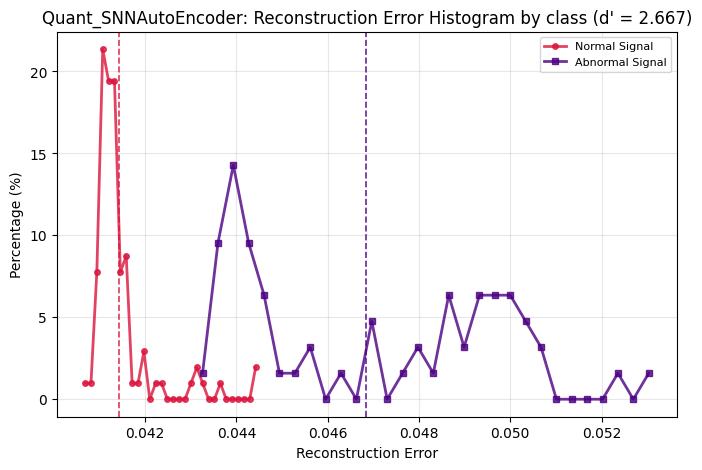

In [22]:
recon_errors = np.array(recon_errors)
test_labels = np.array(test_labels)


# 將 index 和 score 對齊（非必要但保留你的結構）
stack = np.column_stack((np.arange(len(recon_errors)), recon_errors))

# 分類
score_false = stack[test_labels == 0][:, 1]  # 正常樣本
score_true = stack[test_labels == 1][:, 1]  # 異常樣本

# 繪圖
dprime_on_plot = measure_perform.plot_histogram_by_class(score_false, score_true, bins=[30, 30],
                                         model_name=MODEL_NAME, file_name=None,
                                         show_means=True, show_dprime=True, return_dprime=True)




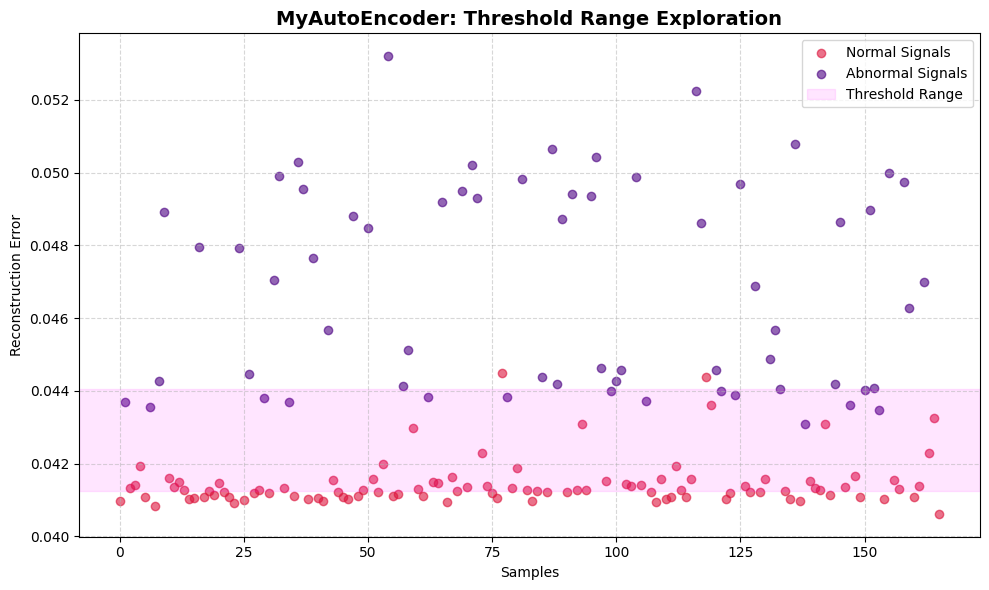

In [23]:
THRESHOLD_MIN = np.percentile(recon_errors, 30)
THRESHOLD_MAX = np.percentile(recon_errors, 70)
measure_perform.plot_threshold_range_exploration(stack, test_labels, threshold_min=THRESHOLD_MIN, threshold_max=THRESHOLD_MAX, model_name="MyAutoEncoder")


In [24]:
THRESHOLD_STEP = 1e-4
thresholds = np.arange(THRESHOLD_MIN, THRESHOLD_MAX + THRESHOLD_STEP, THRESHOLD_STEP)
errors = []

for threshold in thresholds:
    predictions = measure_perform.get_prediction(stack[:, 1], threshold=threshold)
    conf_mat = confusion_matrix(test_labels, predictions)
    errors.append([threshold, conf_mat[1, 0], conf_mat[0, 1]])


errors = np.array(errors)

Saved figure to: best_thr_exp.png


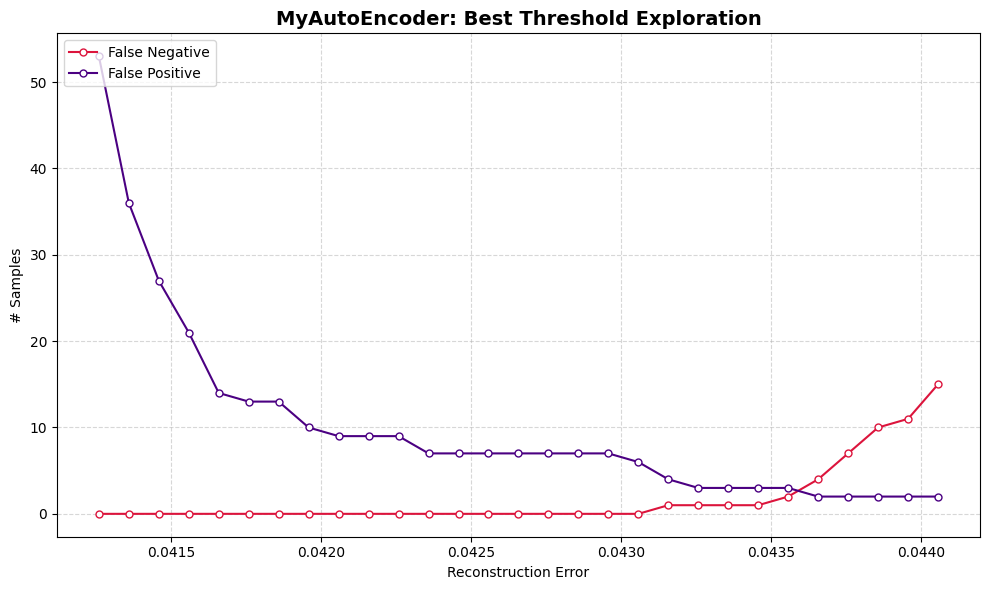

In [25]:
measure_perform.plot_best_threshold_exploration(errors, model_name="MyAutoEncoder", save_path="best_thr_exp.png")


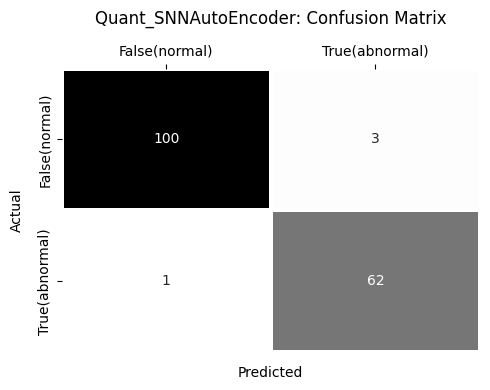

Best THRESHOLD: 0.0433
Accuracy: 97.59%, Precision: 95.38%, Recall: 98.41%, F1: 96.88%
d' = 2.667


In [26]:
best_threshold = None
## 掃描 THRESHOLD (小數點第二位），然後找出使 Accuracy 最佳的 THRESHOLD。
best_accuracy = 0
best_metrics = {}

threshold_range = np.arange(THRESHOLD_MIN, THRESHOLD_MAX, THRESHOLD_STEP) 

for th in threshold_range:
    predictions = measure_perform.get_prediction(stack[:, 1], threshold=th)
    acc = accuracy_score(test_labels, predictions)

    if acc > best_accuracy:
        best_accuracy = acc
        best_threshold = th
        best_metrics = {
            "precision": precision_score(test_labels, predictions),
            "recall": recall_score(test_labels, predictions),
            "f1": f1_score(test_labels, predictions),
            "predictions": predictions
        }

# 繪製最佳門檻的混淆矩陣
measure_perform.plot_confusion_matrix(
    confusion_matrix(test_labels, best_metrics["predictions"]),
    model_name=MODEL_NAME,
    file_name=os.path.join(IMAGE_PATH, "best_conf_mat.svg"),
)

step = THRESHOLD_STEP
# 取出小數位數
decimals = abs(np.floor(np.log10(step))).astype(int) if step < 1 else 0 
# 計算 d' 值
dprime_value = measure_perform.dprime_from_scores(score_false, score_true)


# 輸出結果
print(f"Best THRESHOLD: {best_threshold:.{decimals}f}")
print(
    f"Accuracy: {best_accuracy:.2%}, "
    f"Precision: {best_metrics['precision']:.2%}, "
    f"Recall: {best_metrics['recall']:.2%}, "
    f"F1: {best_metrics['f1']:.2%}"
)
print(f"d' = {dprime_value:.3f}")


AUROC (Area Under Receiver Operating Characteristic Curve)
- **Definition**: The ROC curve plots **FPR** on the x-axis and **TPR(Recall)** on the y-axis.
- **Intuitive Meaning**:
  - AUROC represents the probability that the model will rank any positive example higher than any negative example.
  - AUROC = 0.5 → Equivalent to random guessing
  - AUROC → 1.0 → Perfect separation
- **Useful Scenarios**: When the ratio of positive and negative samples is **balanced**, AUROC is a robust indicator of separation ability.

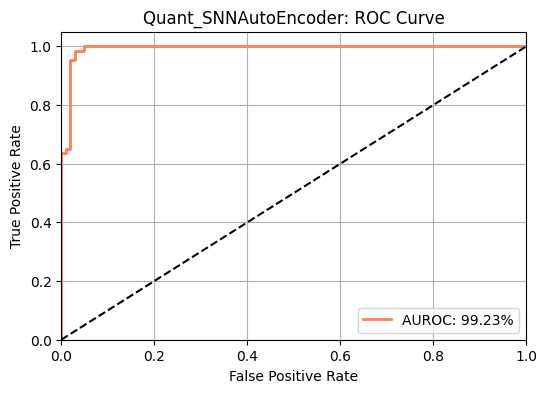

In [29]:
measure_perform.plot_roc_curve(
    roc_curve(test_labels, recon_errors),
    roc_auc_score(test_labels, recon_errors),
    model_name=MODEL_NAME,
    file_name=os.path.join(IMAGE_PATH, "roc_curve.svg"),
)

AUPRC (Area Under Precision-Recall Curve)
- **Definition**: The PR curve has **Recall** on the x-axis and **Precision** on the y-axis.
- **Intuitive Meaning**:
  - AUPR indicates how well a model can maintain **Recall** and **Precision** simultaneously at different thresholds.
  - The baseline AUPR for a random classifier is not 0.5, but the **prevalence** of positive samples.
- **Useful Scenarios**: When the number of positive and negative samples is **severely imbalanced** (such as in anomaly detection), AUPRC more accurately reflects model performance than AUROC.

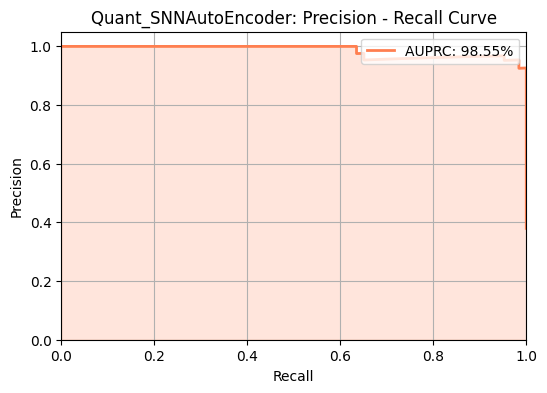

In [28]:
measure_perform.plot_pr_curve(
    precision_recall_curve(test_labels, recon_errors),
    average_precision_score(test_labels, recon_errors),
    model_name=MODEL_NAME,
    file_name=os.path.join(IMAGE_PATH, "pr_curve.svg"),
)

# Inferance

In [14]:
# Load model
# model = SNNAutoEncoder(input_dim=INPUT_SIZE).to(device)
model = Qant_SNNAE(input_dim=INPUT_SIZE).to(device)
model.load_state_dict(torch.load("./models/SNN_QuantAutoencoder_tsri_quant8_test.pth"), strict=False)
HIDDEN_PATH = "./models/SNN_QuantAutoencoder_tsri_quant8_hidden_mean_test.pth"

# --- Inference config ---
K = 5                          
USE_WARMUP_INFER = False      
batch_size = 256
best_threshold = 0.0404

In [15]:
def register_activation_hooks(
    model,
    save_dir: str = "./layer_output",
    sample_idx: int = 0,                   # pick which sample from batch (B, ...)
    flatten_3d: bool = False,              # if True, flatten (B,C,*) -> (B,-1) before saving
    save_weight_bias_once: bool = True,    # save weight/bias only on first call per layer
    save_as_npy: bool = True,              # npy is faster/smaller than txt
    include_patterns=("Conv1d","ConvTranspose1d","ReLU","Linear","BatchNorm1d","Leaky"),
    also_if_classname_contains=(),
    write_quant_each_step: bool = False,   # if True, update quant JSON on every forward
    reset_steps_each_forward: bool = True, # auto-reset step counter before every forward
    warmup_steps: int | None = None,       # prefix "warmup_" if _dump_step < warmup_steps

    # ---- Non-LIF saves ----
    nonlif_save_input: bool = True,        # save inputs[0] for all hooked modules
    nonlif_save_output: bool = False,      # save final tensor "output" for non-LIF modules

    # ---- LIF minimal outputs ----
    lif_save_i_eff: bool = True,           # save "i_eff" (the actual input fed into LIF at step t)
    lif_save_spike: bool = True,           # save "spike" (binary spike at step t)
    lif_save_mem: bool = True,             # save "mem" (PRE-reset membrane at step t)
    lif_save_v_pre: bool = False,          # optional "v_pre" = beta*mem_prev + i_eff
    lif_save_mem_post: bool = False        # optional "mem_post" = mem - spike*thr
):

    os.makedirs(save_dir, exist_ok=True)
    hooks = []
    quant_params = {}  # {"module/name": {"scale": ..., "zero_point": ...}, ...}

    # -------- helpers --------
    def _sanitize(s: str) -> str:
        # Keep slashes to preserve hierarchy; sanitize other chars.
        out = []
        for ch in s:
            if ch.isalnum() or ch in "._-/":
                out.append(ch)
            else:
                out.append("_")
        cleaned = "".join(out).replace("//", "/").strip("/")
        return cleaned if cleaned else "root"

    def _save_array(arr: np.ndarray, path_txt_or_npy: str, as_npy: bool):
        # Save as .npy (default) or .txt
        base, _ = os.path.splitext(path_txt_or_npy)
        if as_npy:
            np.save(base + ".npy", arr)
        else:
            np.savetxt(base + ".txt", arr.reshape(1, -1) if arr.ndim == 1 else arr, fmt="%.8g")

    def _as_tensor_or_scalar(x, like: torch.Tensor):
        """Return scalar or tensor on same device/dtype as `like`."""
        if isinstance(x, torch.Tensor):
            return x.detach().to(device=like.device, dtype=like.dtype)
        if isinstance(x, (list, tuple, np.ndarray)):
            return torch.as_tensor(x, device=like.device, dtype=like.dtype)
        return float(x)  # scalar

    def _broadcast_vec(vec, like: torch.Tensor):
        """Reshape (C,) -> (C,1,1,...) to match `like`'s shape for channel-wise params."""
        if isinstance(vec, torch.Tensor) and vec.ndim == 1:
            return vec.view(-1, *([1] * (like.ndim - 1)))
        return vec

    def _pick_sample(x: torch.Tensor):
        # Slice sample k from (B, ...) tensors; fallback to idx 0
        if not isinstance(x, torch.Tensor):
            return None
        if x.dim() >= 1:
            idx = sample_idx if sample_idx < x.shape[0] else 0
            return x[idx]
        return x

    def need_this_module(m):
        # Select modules to hook (SNN LIF + patterns + classes containing tags)
        cls = m.__class__.__name__
        if snn is not None and isinstance(m, (snn.Leaky, getattr(snn, "RLeaky", ()))):
            return True
        if any(p in cls for p in include_patterns):
            return True
        if any(tag in cls for tag in also_if_classname_contains):
            return True
        return False

    # Pick modules and init per-module step counters
    selected_modules = []
    for name, module in model.named_modules():
        if need_this_module(module):
            module._dump_step = 0  # per-module call index
            selected_modules.append((name, module))

    # Manual reset helper
    def reset_dump_steps():
        for _, m in selected_modules:
            m._dump_step = 0

    # Optional: auto-reset before every forward
    if reset_steps_each_forward:
        def _prehook(_m, _inp):
            # Reset per-forward step counters only
            reset_dump_steps()
            # Clear only temporary per-forward caches
            for _, m in selected_modules:
                for attr in ("_prev_mem_sample", "_mem_prev", "_spk_prev"):
                    if hasattr(m, attr):
                        delattr(m, attr)
        hooks.append(model.register_forward_pre_hook(_prehook))

    # Per-module forward hook
    def get_hook(name, module):
        name_s = _sanitize(name) or "root"

        def hook(mod, inputs, output):
            # Decide prefix by step index vs warmup_steps
            use_warm_prefix = (warmup_steps is not None) and (mod._dump_step < warmup_steps)
            prefix = "warmup_" if use_warm_prefix else ""
            # <save_dir>/<module_name>/<prefix>step_xxx
            layer_dir = os.path.join(save_dir, name_s, f"{prefix}step_{mod._dump_step:03d}")
            os.makedirs(layer_dir, exist_ok=True)

            # ===== INPUT =====
            if nonlif_save_input and isinstance(inputs, (tuple, list)) and len(inputs) > 0 and isinstance(inputs[0], torch.Tensor):
                x = _pick_sample(inputs[0]).detach().cpu()
                arr = x.numpy()
                if flatten_3d and arr.ndim > 1:
                    arr = arr.reshape(1, -1)
                _save_array(arr, os.path.join(layer_dir, "input.txt"), save_as_npy)

            # ===== Check if LIF =====
            is_lif = False
            if snn is not None and isinstance(mod, (snn.Leaky, getattr(snn, "RLeaky", ()))):
                is_lif = True

            if is_lif:
                # ---- LIF outputs ----
                spk_t, mem_t = None, None
                if isinstance(output, torch.Tensor):
                    spk_t = _pick_sample(output)
                    mem_attr = getattr(mod, "mem", None)
                    if isinstance(mem_attr, torch.Tensor):
                        mem_t = _pick_sample(mem_attr)
                elif isinstance(output, (tuple, list)):
                    if len(output) > 0 and isinstance(output[0], torch.Tensor):
                        spk_t = _pick_sample(output[0])
                    if len(output) > 1 and isinstance(output[1], torch.Tensor):
                        mem_t = _pick_sample(output[1])
                    if mem_t is None:
                        mem_attr = getattr(mod, "mem", None)
                        if isinstance(mem_attr, torch.Tensor):
                            mem_t = _pick_sample(mem_attr)
                else:
                    spk_attr = getattr(mod, "spk", None)
                    if isinstance(spk_attr, torch.Tensor):
                        spk_t = _pick_sample(spk_attr)
                    mem_attr = getattr(mod, "mem", None)
                    if isinstance(mem_attr, torch.Tensor):
                        mem_t = _pick_sample(mem_attr)

                # true input to LIF this step (use inputs[0])
                x_in_t = None
                if isinstance(inputs, (tuple, list)) and len(inputs) > 0 and isinstance(inputs[0], torch.Tensor):
                    x_in_t = _pick_sample(inputs[0]).detach()

                # Minimal saves
                if lif_save_i_eff and x_in_t is not None:
                    _save_array(x_in_t.cpu().numpy(), os.path.join(layer_dir, "i_eff.txt"), save_as_npy)
                if lif_save_spike and isinstance(spk_t, torch.Tensor):
                    _save_array(spk_t.detach().cpu().numpy(), os.path.join(layer_dir, "spike.txt"), save_as_npy)
                if lif_save_mem and isinstance(mem_t, torch.Tensor):
                    _save_array(mem_t.detach().cpu().numpy(), os.path.join(layer_dir, "mem.txt"), save_as_npy)

                # Optional extras from confirmed recurrence
                if (lif_save_v_pre or lif_save_mem_post) and isinstance(mem_t, torch.Tensor):
                    thr_attr  = getattr(mod, "threshold", 1.0)
                    beta_attr = getattr(mod, "beta", 0.75)
                    thr_t  = _as_tensor_or_scalar(thr_attr,  mem_t)
                    beta_t = _as_tensor_or_scalar(beta_attr, mem_t)
                    if isinstance(thr_t, torch.Tensor):  thr_t  = _broadcast_vec(thr_t,  mem_t)
                    if isinstance(beta_t, torch.Tensor): beta_t = _broadcast_vec(beta_t, mem_t)

                    # prev caches (init zeros if absent)
                    mem_prev = getattr(mod, "_mem_prev", torch.zeros_like(mem_t))
                    spk_prev_like = spk_t if isinstance(spk_t, torch.Tensor) else mem_t
                    spk_prev = getattr(mod, "_spk_prev", torch.zeros_like(spk_prev_like))

                    # v_pre = beta*mem_prev + i_eff
                    if lif_save_v_pre and (x_in_t is not None):
                        v_pre = beta_t * mem_prev + x_in_t
                        _save_array(v_pre.detach().cpu().numpy(), os.path.join(layer_dir, "v_pre.txt"), save_as_npy)

                    # mem_post = mem - spike*thr
                    if lif_save_mem_post and isinstance(spk_t, torch.Tensor):
                        thr_used = thr_t if isinstance(thr_t, torch.Tensor) else float(thr_t)
                        mem_post = mem_t - spk_t * thr_used
                        _save_array(mem_post.detach().cpu().numpy(), os.path.join(layer_dir, "mem_post.txt"), save_as_npy)

                    # update caches for next step
                    mod._mem_prev = mem_t.detach()
                    if isinstance(spk_t, torch.Tensor):
                        mod._spk_prev = spk_t.detach()

            else:
                # ===== Non-LIF: output (optional) =====
                if nonlif_save_output and isinstance(output, torch.Tensor):
                    y = _pick_sample(output).detach().cpu().numpy()
                    if flatten_3d and y.ndim > 1:
                        y = y.reshape(1, -1)
                    _save_array(y, os.path.join(layer_dir, "output.txt"), save_as_npy)

            # ===== OPTIONAL intermediates (if your modules expose them) =====
            if hasattr(mod, "out") and isinstance(mod.out, torch.Tensor):
                y0 = _pick_sample(mod.out).detach().cpu().numpy()
                if flatten_3d and y0.ndim > 1:
                    y0 = y0.reshape(1, -1)
                _save_array(y0, os.path.join(layer_dir, "prequant_output.txt"), save_as_npy)
            if hasattr(mod, "latest_qx") and isinstance(mod.latest_qx, torch.Tensor):
                qx = _pick_sample(mod.latest_qx).detach().cpu().numpy()
                if flatten_3d and qx.ndim > 1:
                    qx = qx.reshape(1, -1)
                _save_array(qx, os.path.join(layer_dir, "q_x.txt"), save_as_npy)
            if hasattr(mod, "out_int") and isinstance(mod.out_int, torch.Tensor) and mod.out_int.numel() > 0:
                oi = _pick_sample(mod.out_int).detach().cpu().numpy()
                if flatten_3d and oi.ndim > 1:
                    oi = oi.reshape(1, -1)
                _save_array(oi, os.path.join(layer_dir, "out_int.txt"), save_as_npy)
            if hasattr(mod, "out_dq") and isinstance(mod.out_dq, torch.Tensor) and mod.out_dq.numel() > 0:
                od = _pick_sample(mod.out_dq).detach().cpu().numpy()
                if flatten_3d and od.ndim > 1:
                    od = od.reshape(1, -1)
                _save_array(od, os.path.join(layer_dir, "out_dq.txt"), save_as_npy)

            # ===== WEIGHT / BIAS =====
            if hasattr(mod, "weight") and mod.weight is not None:
                if (mod._dump_step == 0) or (not save_weight_bias_once):
                    _save_array(mod.weight.detach().cpu().numpy(),
                                os.path.join(layer_dir, "weight.txt"), save_as_npy)
            if hasattr(mod, "bias") and mod.bias is not None:
                if (mod._dump_step == 0) or (not save_weight_bias_once):
                    _save_array(mod.bias.detach().cpu().numpy(),
                                os.path.join(layer_dir, "bias.txt"), save_as_npy)
                    
            if hasattr(mod, "bias_int") and isinstance(mod.bias_int, torch.Tensor) and mod.bias_int.numel() > 0:
                _save_array(mod.bias_int.detach().cpu().numpy(),
                            os.path.join(layer_dir, "bias_int.txt"), save_as_npy)

            if hasattr(mod, "bias_dq") and isinstance(mod.bias_dq, torch.Tensor) and mod.bias_dq.numel() > 0:
                _save_array(mod.bias_dq.detach().cpu().numpy(),
                            os.path.join(layer_dir, "bias_dq.txt"), save_as_npy)
                    

            if hasattr(mod, "weight_int") and isinstance(mod.weight_int, torch.Tensor) and mod.weight_int.numel() > 0:
                _save_array(mod.weight_int.detach().cpu().numpy(),
                            os.path.join(layer_dir, "weight_int.txt"), save_as_npy)
            if hasattr(mod, "weight_dq") and isinstance(mod.weight_dq, torch.Tensor) and mod.weight_dq.numel() > 0:
                _save_array(mod.weight_dq.detach().cpu().numpy(),
                            os.path.join(layer_dir, "weight_dq.txt"), save_as_npy)

            # ===== CENTRALIZED QUANT PARAMS (scale / zero_point only) =====
            qentry = quant_params.get(name_s, {})
            if hasattr(mod, 'scale'):
                s = mod.scale
                if isinstance(s, torch.Tensor): s = s.detach().cpu().numpy()
                if isinstance(s, np.ndarray):   s = s.tolist()
                try: s = float(s) if not isinstance(s, (list, dict)) else s
                except: pass
                qentry["scale"] = s
            zp_obj = None
            for cand in ("zero_point", "zeropoint", "zeroPoint"):
                if hasattr(mod, cand):
                    zp_obj = getattr(mod, cand); break
            if zp_obj is not None:
                if isinstance(zp_obj, torch.Tensor): zp_obj = zp_obj.detach().cpu().numpy()
                if isinstance(zp_obj, np.ndarray):   zp_obj = zp_obj.tolist()
                try: zp_obj = float(zp_obj) if not isinstance(zp_obj, (list, dict)) else zp_obj
                except: pass
                qentry["zero_point"] = zp_obj
            if qentry:
                quant_params[name_s] = qentry
                if write_quant_each_step:
                    with open(os.path.join(save_dir, "quant_params.json"), "w", encoding="utf-8") as f:
                        json.dump(quant_params, f, ensure_ascii=False, indent=2)

            # increment per-layer call index
            mod._dump_step += 1

        return hook

    # Register per-module forward hooks
    for name, module in selected_modules:
        hooks.append(module.register_forward_hook(get_hook(name, module)))

    def save_quant_params():
        """Write all collected quant params to a single JSON file."""
        path = os.path.join(save_dir, "quant_params.json")
        with open(path, "w", encoding="utf-8") as f:
            json.dump(quant_params, f, ensure_ascii=False, indent=2)
        return path

    return hooks, save_quant_params, reset_dump_steps


In [17]:
# === Load data ===
test_data   = load_pickle(os.path.join(MERGE_OUTPUT_PATH, "test_data_combined.pkl"))
file_slices = load_pickle(os.path.join(MERGE_OUTPUT_PATH, "test_file_slices.pkl"))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

hooks, save_q, _ = register_activation_hooks(
    model,
    save_dir="./layer_output2",
    sample_idx=0,
    save_as_npy=True,
    include_patterns=(
        "Leaky","Conv1d","ConvTranspose1d","Linear"),
    also_if_classname_contains=("Quant",),
    nonlif_save_output=True, 
    lif_save_i_eff=True,
    lif_save_mem=True,
    lif_save_spike=True,
    lif_save_v_pre=False, 
    lif_save_mem_post=False
)


In [ ]:
# === Select one file to test ===
i = 10
s, e = file_slices[i]
test_tensor = torch.tensor(test_data[s:e], dtype=torch.float32, device=device)
print(f"Testing file index {i}, shape: {tuple(test_tensor.shape)}")

# === Inference settings ===
model.eval()
model.reset_on_forward = False   # do NOT auto-reset hidden states during forward

recon_errors = []
N = test_tensor.shape[0]

with torch.inference_mode():
    for start in tqdm(range(0, N, batch_size), desc="Inference"):
        end = min(start + batch_size, N)
        
        # 1. 取出已經是 0/1 的脈衝輸入 (變數改名為 x_spikes)
        x_spikes = test_tensor[start:end]   # (B, T, F)
        B = x_spikes.size(0)

        # 2. Target 是輸入脈衝在時間軸上的平均 (Firing Rate)
        target_prob = x_spikes.mean(dim=1)  # (B, F)

        # 3. 載入 Hidden State
        model.load_hidden_from_file(HIDDEN_PATH, batch_size=B, device=device)

        # 4. 設定輸入 (直接使用 x_spikes，不需再做 Bernoulli)
        x_in = x_spikes   # (B, T, F)

        # 5. Single forward pass (無重置、無 Warm-up)
        y_rate = model(x_in, warmup_spike=None, reset_state=False)  # (B, F)

        # 6. 計算與 Target 的 MSE
        mse_per_sample = F.mse_loss(y_rate, target_prob, reduction="none").mean(dim=1)
        recon_errors.extend(mse_per_sample.detach().cpu().tolist())

# === Convert to numpy ===
recon_errors = np.asarray(recon_errors, dtype=np.float32)
file_mse = float(np.mean(recon_errors))

# Convention: 1 => Abnormal, 0 => Normal
gt_is_abnormal = bool(int(test_labels[i]))     # True if 1.0, False if 0.0
gt_label = "Abnormal" if gt_is_abnormal else "Normal"

# Determine predicted anomaly
is_anomaly = (file_mse > float(best_threshold))
pred_label = "Abnormal" if is_anomaly else "Normal"

# --- Print summary ---
print(f"MSE: {file_mse:.6f} | Best_threshold: {best_threshold:.6f}")
print(f"Prediction: {pred_label} | Ground Truth: {gt_label}")

# ===== Save quant params JSON once at the end =====
quant_json_path = save_q()
print(f"Quant params saved to: {quant_json_path}")

for h in hooks:
    h.remove()

Testing file index 10, shape: (5997, 6, 480)


Inference:   0%|          | 0/24 [00:00<?, ?it/s]

x_prob: tensor([[[1., 0., 1.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 0.],
         [0., 1., 1.,  ..., 0., 0., 0.],
         [0., 1., 1.,  ..., 0., 0., 0.],
         [1., 0., 1.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 0.]],

        [[1., 1., 1.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 0.],
         [0., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 0.,  ..., 0., 0., 0.],
         [0., 1., 1.,  ..., 0., 0., 0.],
         [0., 1., 1.,  ..., 0., 0., 0.]],

        [[1., 1., 1.,  ..., 0., 0., 0.],
         [0., 1., 1.,  ..., 0., 0., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.],
         [1., 0., 1.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.]],

        ...,

        [[1., 1., 1.,  ..., 0., 0., 0.],
         [0., 1., 1.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [0., 1., 1.,  ..., 0

Inference:   4%|▍         | 1/24 [00:00<00:10,  2.18it/s]

x_prob: tensor([[[0., 0., 0.,  ..., 0., 1., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 0., 1.,  ..., 0., 0., 0.],
         [0., 1., 1.,  ..., 0., 0., 0.]],

        [[0., 1., 0.,  ..., 0., 0., 0.],
         [1., 0., 1.,  ..., 0., 0., 0.],
         [0., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [0., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 1.,  ..., 0., 0., 0.],
         [1., 1., 0.,  ..., 0., 0., 0.],
         [1., 1., 0.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [0., 1., 1.,  ..., 0., 0., 0.]],

        ...,

        [[1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [0., 1., 1.,  ..., 0., 0., 0.],
         [0., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0

Inference:   8%|▊         | 2/24 [00:00<00:08,  2.61it/s]

x_prob: tensor([[[0., 1., 1.,  ..., 0., 0., 0.],
         [0., 1., 1.,  ..., 0., 0., 0.],
         [0., 1., 1.,  ..., 0., 0., 0.],
         [1., 0., 1.,  ..., 0., 0., 0.],
         [0., 1., 1.,  ..., 0., 0., 0.],
         [0., 1., 1.,  ..., 0., 0., 0.]],

        [[1., 1., 1.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.]],

        [[1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 0.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [0., 1., 1.,  ..., 0., 0., 0.]],

        ...,

        [[1., 1., 0.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0

Inference:  12%|█▎        | 3/24 [00:01<00:07,  2.76it/s]

x_prob: tensor([[[0., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 0., 1.,  ..., 0., 0., 0.],
         [0., 1., 1.,  ..., 0., 0., 1.],
         [1., 1., 0.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 0.]],

        [[0., 1., 0.,  ..., 0., 0., 1.],
         [1., 1., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 1.,  ..., 0., 0., 0.],
         [1., 1., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[1., 1., 1.,  ..., 0., 0., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 0.],
         [0., 1., 1.,  ..., 0., 0., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.]],

        ...,

        [[1., 0., 1.,  ..., 0., 0., 0.],
         [0., 1., 1.,  ..., 0., 0., 0.],
         [1., 0., 1.,  ..., 0., 0., 0.],
         [0., 1., 1.,  ..., 0., 0., 1.],
         [1., 1., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0

Inference:  17%|█▋        | 4/24 [00:01<00:06,  2.86it/s]

x_prob: tensor([[[0., 1., 1.,  ..., 0., 0., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 0.],
         [0., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [0., 1., 1.,  ..., 0., 0., 0.]],

        [[1., 1., 1.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [0., 1., 1.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 0.],
         [0., 1., 1.,  ..., 0., 0., 0.]],

        [[1., 1., 1.,  ..., 0., 0., 0.],
         [1., 0., 1.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.],
         [1., 0., 1.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.]],

        ...,

        [[1., 1., 1.,  ..., 0., 0., 0.],
         [0., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 0., 1.,  ..., 0., 1., 0.],
         [1., 0., 1.,  ..., 0

Inference:  21%|██        | 5/24 [00:01<00:06,  2.89it/s]

x_prob: tensor([[[0., 1., 1.,  ..., 0., 0., 0.],
         [1., 0., 1.,  ..., 0., 0., 0.],
         [1., 1., 0.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 0., 1.,  ..., 0., 0., 0.],
         [0., 1., 1.,  ..., 0., 0., 0.]],

        [[1., 1., 1.,  ..., 0., 0., 0.],
         [0., 1., 1.,  ..., 0., 0., 0.],
         [0., 1., 1.,  ..., 0., 0., 0.],
         [1., 0., 1.,  ..., 0., 0., 0.],
         [1., 0., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.]],

        [[1., 1., 1.,  ..., 0., 0., 0.],
         [1., 0., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.]],

        ...,

        [[1., 0., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 1.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0

Inference:  25%|██▌       | 6/24 [00:02<00:06,  2.94it/s]

x_prob: tensor([[[1., 0., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 1., 0., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 0.],
         [1., 0., 1.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 1.]],

        [[1., 1., 1.,  ..., 0., 0., 0.],
         [0., 1., 1.,  ..., 0., 0., 0.],
         [0., 1., 1.,  ..., 0., 0., 0.],
         [0., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.]],

        [[1., 1., 1.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 1.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.]],

        ...,

        [[0., 0., 1.,  ..., 1., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 0.],
         [0., 1., 1.,  ..., 0., 0., 0.],
         [0., 1., 1.,  ..., 0., 0., 0.],
         [0., 1., 1.,  ..., 0

Inference:  29%|██▉       | 7/24 [00:02<00:05,  2.97it/s]

x_prob: tensor([[[1., 0., 1.,  ..., 1., 0., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [0., 1., 1.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 1.,  ..., 0., 0., 0.]],

        [[0., 1., 1.,  ..., 0., 0., 0.],
         [0., 1., 1.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 1., 0.],
         [0., 0., 1.,  ..., 0., 1., 0.]],

        [[1., 1., 0.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 1., 1.,  ..., 0., 0., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.],
         [0., 1., 1.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0

Inference:  33%|███▎      | 8/24 [00:02<00:05,  2.97it/s]

x_prob: tensor([[[1., 0., 1.,  ..., 0., 0., 0.],
         [1., 1., 0.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 1., 1.,  ..., 0., 0., 0.],
         [1., 0., 1.,  ..., 0., 0., 0.]],

        [[0., 1., 1.,  ..., 0., 1., 0.],
         [1., 1., 0.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 0.],
         [0., 1., 1.,  ..., 0., 0., 0.],
         [0., 1., 1.,  ..., 0., 1., 0.],
         [1., 0., 1.,  ..., 0., 1., 0.]],

        [[0., 0., 1.,  ..., 0., 0., 0.],
         [0., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [0., 1., 1.,  ..., 0., 0., 0.],
         [0., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.]],

        ...,

        [[0., 1., 1.,  ..., 1., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [0., 1., 1.,  ..., 0., 1., 0.],
         [0., 1., 1.,  ..., 0., 0., 0.],
         [0., 1., 1.,  ..., 0., 0., 0.],
         [0., 1., 1.,  ..., 0

Inference:  38%|███▊      | 9/24 [00:03<00:05,  2.99it/s]

x_prob: tensor([[[1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [0., 1., 1.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 0.],
         [1., 0., 1.,  ..., 1., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.]],

        [[1., 0., 1.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 0.,  ..., 0., 0., 0.]],

        [[1., 0., 0.,  ..., 0., 0., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.],
         [1., 1., 0.,  ..., 1., 0., 0.],
         [0., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.]],

        ...,

        [[0., 1., 0.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [0., 1., 1.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0

Inference:  42%|████▏     | 10/24 [00:03<00:04,  2.99it/s]

x_prob: tensor([[[0., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 0.],
         [0., 1., 1.,  ..., 0., 0., 0.],
         [0., 1., 1.,  ..., 1., 1., 0.]],

        [[1., 1., 1.,  ..., 0., 0., 0.],
         [0., 1., 1.,  ..., 0., 1., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [0., 1., 1.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 1.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 1.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 0.],
         [0., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.]],

        ...,

        [[0., 1., 1.,  ..., 0., 0., 0.],
         [1., 0., 1.,  ..., 0., 0., 1.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         [1., 1., 0.,  ..., 0

Inference:  46%|████▌     | 11/24 [00:03<00:04,  2.98it/s]

x_prob: tensor([[[1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 0.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 0., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.]],

        [[1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [0., 1., 1.,  ..., 0., 1., 0.],
         [1., 1., 0.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 0., 1.,  ..., 0., 0., 0.]],

        [[1., 1., 0.,  ..., 0., 0., 0.],
         [1., 0., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 0., 1.,  ..., 0., 0., 0.]],

        ...,

        [[0., 0., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 1., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 0.],
         [0., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0

Inference:  50%|█████     | 12/24 [00:04<00:03,  3.00it/s]

x_prob: tensor([[[1., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 1., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.]],

        [[1., 1., 1.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.],
         [1., 0., 1.,  ..., 0., 0., 0.]],

        [[0., 0., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [0., 1., 1.,  ..., 0., 1., 0.],
         [0., 1., 1.,  ..., 0., 0., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.]],

        ...,

        [[0., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [0., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [0., 1., 1.,  ..., 0

Inference:  54%|█████▍    | 13/24 [00:04<00:03,  2.99it/s]

x_prob: tensor([[[1., 1., 1.,  ..., 0., 0., 0.],
         [0., 1., 1.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 0.],
         [0., 1., 1.,  ..., 0., 0., 0.]],

        [[0., 1., 1.,  ..., 0., 0., 0.],
         [0., 1., 0.,  ..., 1., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.]],

        [[0., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 0., 1.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 0.],
         [1., 0., 1.,  ..., 0., 0., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.]],

        ...,

        [[0., 0., 1.,  ..., 0., 1., 0.],
         [0., 1., 1.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         [1., 1., 0.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 0.],
         [0., 1., 1.,  ..., 0

Inference:  58%|█████▊    | 14/24 [00:04<00:03,  3.01it/s]

x_prob: tensor([[[0., 1., 1.,  ..., 0., 0., 0.],
         [0., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 0., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [0., 1., 1.,  ..., 0., 0., 0.]],

        [[1., 1., 0.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 0.],
         [0., 1., 1.,  ..., 0., 0., 0.],
         [0., 1., 1.,  ..., 0., 0., 0.],
         [0., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 0.,  ..., 0., 0., 0.]],

        [[0., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 0.,  ..., 0., 0., 0.],
         [0., 1., 1.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 0.]],

        ...,

        [[1., 1., 0.,  ..., 0., 0., 0.],
         [1., 0., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [0., 1., 1.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 0.],
         [0., 1., 0.,  ..., 0

Inference:  62%|██████▎   | 15/24 [00:05<00:02,  3.01it/s]

x_prob: tensor([[[1., 0., 1.,  ..., 0., 0., 0.],
         [0., 1., 1.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 0.],
         [0., 1., 1.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 1., 0., 0.]],

        [[1., 0., 1.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 1., 0.],
         [1., 0., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.]],

        [[1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [0., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.]],

        ...,

        [[0., 1., 1.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 1., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [0., 1., 1.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0

Inference:  67%|██████▋   | 16/24 [00:05<00:02,  3.02it/s]

x_prob: tensor([[[0., 1., 1.,  ..., 0., 0., 0.],
         [1., 0., 1.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         [1., 1., 0.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 0.],
         [1., 1., 0.,  ..., 0., 0., 0.]],

        [[1., 1., 1.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 0.],
         [0., 1., 1.,  ..., 0., 0., 0.],
         [0., 1., 1.,  ..., 0., 0., 0.],
         [1., 0., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.]],

        [[1., 0., 1.,  ..., 0., 0., 0.],
         [0., 1., 1.,  ..., 0., 0., 0.],
         [0., 1., 1.,  ..., 0., 0., 0.],
         [0., 1., 1.,  ..., 0., 0., 0.],
         [0., 1., 1.,  ..., 0., 0., 0.],
         [1., 0., 1.,  ..., 0., 0., 0.]],

        ...,

        [[1., 0., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0

Inference:  71%|███████   | 17/24 [00:05<00:02,  3.03it/s]

x_prob: tensor([[[1., 0., 1.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         [0., 1., 1.,  ..., 0., 0., 0.],
         [0., 1., 1.,  ..., 0., 0., 0.]],

        [[0., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.],
         [0., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 0., 1.,  ..., 0., 0., 0.]],

        [[0., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [0., 1., 1.,  ..., 0., 0., 0.],
         [0., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.]],

        ...,

        [[1., 1., 0.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 0., 1.,  ..., 0., 0., 0.],
         [1., 1., 0.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0

Inference:  75%|███████▌  | 18/24 [00:06<00:01,  3.05it/s]

x_prob: tensor([[[0., 1., 1.,  ..., 0., 0., 0.],
         [0., 1., 1.,  ..., 0., 0., 0.],
         [1., 0., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [0., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.]],

        [[1., 0., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [0., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 1., 1.,  ..., 0., 0., 0.],
         [1., 0., 1.,  ..., 0., 0., 0.],
         [0., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [0., 1., 1.,  ..., 0., 0., 0.]],

        ...,

        [[1., 1., 1.,  ..., 0., 0., 0.],
         [0., 1., 1.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 0.,  ..., 0

Inference:  79%|███████▉  | 19/24 [00:06<00:01,  3.04it/s]

x_prob: tensor([[[0., 0., 1.,  ..., 0., 0., 0.],
         [1., 0., 1.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [0., 1., 1.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 1., 0.]],

        [[0., 0., 1.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [0., 1., 1.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 1., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 0.,  ..., 0., 0., 0.]],

        ...,

        [[1., 0., 1.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0

Inference:  83%|████████▎ | 20/24 [00:06<00:01,  3.03it/s]

x_prob: tensor([[[1., 1., 1.,  ..., 0., 0., 0.],
         [0., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 1., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.],
         [0., 1., 1.,  ..., 0., 0., 0.]],

        [[0., 0., 1.,  ..., 0., 0., 0.],
         [1., 1., 0.,  ..., 0., 0., 0.],
         [1., 1., 0.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [0., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.]],

        [[1., 1., 1.,  ..., 0., 0., 0.],
         [0., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 0.]],

        ...,

        [[1., 0., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 0.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 0.],
         [0., 1., 1.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0

Inference:  88%|████████▊ | 21/24 [00:07<00:00,  3.05it/s]

x_prob: tensor([[[1., 1., 1.,  ..., 0., 0., 0.],
         [0., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [0., 1., 1.,  ..., 0., 0., 0.],
         [1., 0., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.]],

        [[1., 0., 1.,  ..., 0., 0., 0.],
         [1., 0., 1.,  ..., 0., 0., 0.],
         [0., 1., 1.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 1., 0.]],

        [[0., 1., 1.,  ..., 1., 0., 0.],
         [0., 1., 1.,  ..., 0., 0., 0.],
         [0., 1., 1.,  ..., 0., 0., 0.],
         [0., 1., 1.,  ..., 0., 0., 0.],
         [1., 0., 1.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 0.]],

        ...,

        [[0., 1., 1.,  ..., 0., 0., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.],
         [0., 1., 1.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0

Inference:  92%|█████████▏| 22/24 [00:07<00:00,  3.06it/s]

x_prob: tensor([[[1., 0., 1.,  ..., 0., 0., 0.],
         [1., 0., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [0., 1., 1.,  ..., 1., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.]],

        [[1., 0., 1.,  ..., 0., 0., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.],
         [0., 1., 1.,  ..., 0., 0., 1.],
         [1., 0., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.]],

        [[0., 0., 1.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 1., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 0.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 0.]],

        ...,

        [[0., 1., 1.,  ..., 0., 0., 0.],
         [0., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 0., 1.,  ..., 0

Inference:  96%|█████████▌| 23/24 [00:07<00:00,  3.07it/s]

x_prob: tensor([[[0., 1., 1.,  ..., 0., 0., 0.],
         [1., 0., 1.,  ..., 0., 0., 0.],
         [1., 0., 1.,  ..., 0., 0., 0.],
         [1., 0., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 1.],
         [1., 0., 1.,  ..., 0., 0., 0.]],

        [[1., 0., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 0.],
         [1., 0., 1.,  ..., 0., 0., 1.],
         [1., 0., 1.,  ..., 0., 0., 0.],
         [0., 1., 1.,  ..., 0., 1., 0.]],

        [[1., 1., 1.,  ..., 0., 0., 0.],
         [1., 0., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 0., 1.,  ..., 0., 0., 0.],
         [1., 0., 1.,  ..., 0., 0., 0.]],

        ...,

        [[1., 1., 1.,  ..., 0., 0., 0.],
         [1., 0., 1.,  ..., 0., 0., 0.],
         [0., 1., 1.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0

Inference: 100%|██████████| 24/24 [00:08<00:00,  2.98it/s]

MSE: 0.041093 | Best_threshold: 0.040400
Prediction: Abnormal | Ground Truth: Normal
Quant params saved to: ./layer_output2\quant_params.json
